<a href="https://colab.research.google.com/github/VPonomarev42/LearningRep/blob/main/stats/stats_miniproject_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задание
В этом занятии предстоит протестировать несколько гипотез.

Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

### Вопросы для проверки:
* Есть ли различия в размерах оттока клиентов в разных городах (churn, city)
* Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)
* Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

### Описание данных
* city – город
* phone – основное устройство, которое использует водитель
* signup_date – дата регистрации аккаунта (YYYYMMDD)
* last_trip_date – дата последней поездки (YYYYMMDD)
* avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
* avg_rating_by_driver – средняя оценка поездок водителем
* avg_rating_of_driver – средняя оценка поездок водителя
* surge_pct – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
* avg_surge – средний множитель всплеска за все поездки этого водителя
* trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после регистрации
* luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
* weekday_pct – процент поездок пользователя, совершенных в будние дни


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pylab as plt

from scipy.stats import iqr
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from tqdm.auto import tqdm

%matplotlib inline
sns.set(rc={'figure.figsize':(10,5)}, style='whitegrid')

## 1. Загрузим данные и посмотрим на них

In [ ]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/406362/churn.csv', parse_dates=['signup_date', 'last_trip_date'])
data

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5.63,4.2,5.0,1.00,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0
49996,0.00,4.0,NaN,1.00,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0
49997,3.86,5.0,5.0,1.00,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0
49998,4.58,3.5,3.0,1.00,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0


In [ ]:
data.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
dtype: object

In [ ]:
data.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

## 2. Разметим водителей как churn, если они не пользовались сервисом больше 30 дней

In [ ]:
data.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [ ]:
data['last_activity'] = data.last_trip_date.max() - data.last_trip_date

In [ ]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,last_activity
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14 days
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57 days
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175 days
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2 days
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108 days


In [ ]:
data['last_activity'] = data['last_activity'].dt.days

In [ ]:
data['churn'] = data.last_activity.apply(lambda x: 'churn' if x > 30 else 'not churn')

In [ ]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,last_activity,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14,not churn
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57,churn
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175,churn
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2,not churn
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108,churn


In [ ]:
data['churn'].value_counts()

churn        31196
not churn    18804
Name: churn, dtype: int64

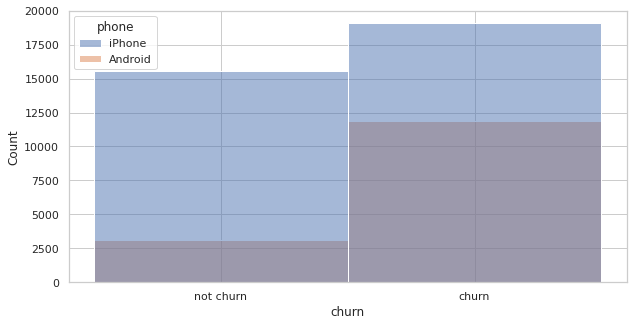

In [ ]:
sns.histplot(data=data, x='churn', hue='phone')

## 2. Проверим, есть ли различия в размерах оттока клиентов в разных городах (churn, city)


In [ ]:
data.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [ ]:
city_churn = data.groupby(['city','churn'], as_index=False).agg({'avg_dist':'count'}).rename(columns={'avg_dist':'count'})
city_churn

,city,churn,count
0,Astapor,churn,12306
1,Astapor,not churn,4228
2,King's Landing,churn,3767
3,King's Landing,not churn,6363
4,Winterfell,churn,15123
5,Winterfell,not churn,8213


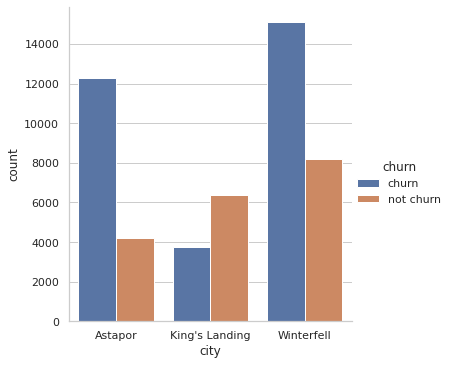

In [ ]:
sns.catplot(x="city", y="count",
                hue="churn", 
                data=city_churn, kind="bar");

In [ ]:
city_churn.pivot(index='city', columns='churn', values='count')

churn,churn,not churn
city,,
Astapor,12306,4228
King's Landing,3767,6363
Winterfell,15123,8213


Нам необходимо сравнить различия между 2-мя номинативные группами: city, churn. Будем это делать с помощью кси-квадрат. 

In [ ]:
chi2_stat, p, ddof, epctd = chi2_contingency(city_churn.pivot(index='city', columns='churn', values='count'))

In [ ]:
chi2_stat, p

(3821.5510225559638, 0.0)

Метод показал p-value < 0.05, что позволяет нам отбросить нулевую гипотезу об отсутствии различий между этими группами. Значит взаимосвязь  между оттоком и город присутствует. Правда мы не можем говорить о том, что именно город является причиной такого оттока. Скорее всего, на это влияет какой-то другой фактор или совокупность факторов

## 3. Проверим различия между активностью в первые 30 дней с момента регистрации между водителями из разных городов

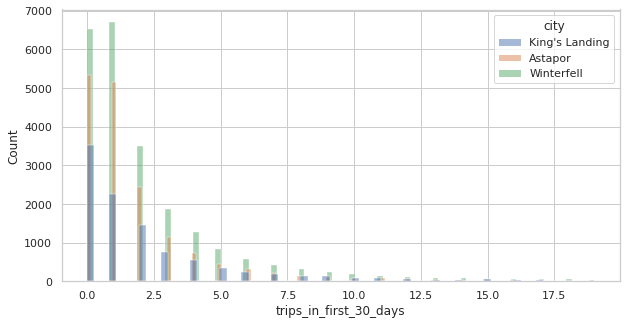

In [ ]:
sns.histplot(data=data[data.trips_in_first_30_days < 20], x='trips_in_first_30_days', hue='city', common_bins=False)

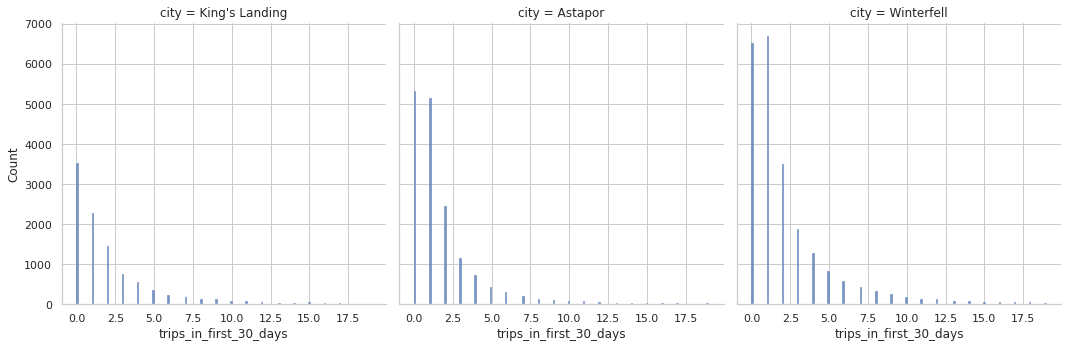

In [ ]:
sns.displot(data=data[data.trips_in_first_30_days < 20], x='trips_in_first_30_days', col='city')

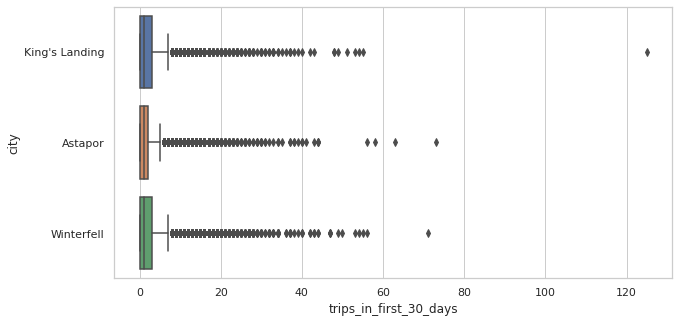

In [ ]:
sns.boxplot(data=data, x='trips_in_first_30_days', y='city')

In [ ]:
data.groupby(['city']).trips_in_first_30_days.describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Astapor,16534.0,1.948651,3.333600,0.0,0.0,1.0,2.0,73.0
King's Landing,10130.0,2.463672,4.326140,0.0,0.0,1.0,3.0,125.0
Winterfell,23336.0,2.431179,3.835147,0.0,0.0,1.0,3.0,71.0


Из графиков и описательной статистики можем сказать:
*   Распределение ассимитричное, скошенное влево с половиной всех показаний в 0
*   Медианое количество поездок во всех городах является 1
*   В городе King's Landing меньшее количество водителей, однако в этом городе имеется самый большой выброс, который увеличивается дисперсию этого распределния. 



Проверим на нормальность распределния в этих городах с помощью метода Шапиро-Уилка

In [ ]:
trips_Astapor = data[data.city == 'Astapor'].trips_in_first_30_days
trips_Kings = data[data.city == "King's Landing"].trips_in_first_30_days
trips_Winterfell = data[data.city == "Winterfell"].trips_in_first_30_days

In [ ]:
shapiro(trips_Astapor.sample(1000,random_state=17))

(0.5414707660675049, 4.203895392974451e-45)

In [ ]:
shapiro(trips_Kings.sample(1000,random_state=17))

(0.6132159233093262, 1.6829594556541053e-42)

In [ ]:
shapiro(trips_Winterfell.sample(1000,random_state=17))

(0.5455795526504517, 7.006492321624085e-45)

Для всех трёх городов тест показал статистически значимые различия, что может судить о том, что данные распределены ненормально

Данные распределены ненормально, мы не можем применить трансформацию данных, например взять логарифм, так как значительное количество наблюдений равняется 0.
Также мы имеем 3 группы. Мы приходим к ANOVA, точнее к её непараметрическому аналогу критерию Краскела-Уоллиса

In [ ]:
from scipy.stats import kruskal


In [ ]:
kruskal(trips_Astapor, trips_Kings, trips_Winterfell)

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

Стат-значимые различия есть, осталось понять где.

In [ ]:
kruskal(trips_Astapor, trips_Kings)

KruskalResult(statistic=32.85849427578329, pvalue=9.911703095724167e-09)

In [ ]:
kruskal(trips_Astapor, trips_Winterfell)

KruskalResult(statistic=226.10121736401675, pvalue=4.2231166438494773e-51)

In [ ]:
kruskal(trips_Kings, trips_Winterfell)

KruskalResult(statistic=35.57113437313601, pvalue=2.45904556774695e-09)

In [ ]:
%pip install scikit-posthocs


In [ ]:
import scikit_posthocs as sp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
sp.posthoc_dunn([trips_Astapor, trips_Kings, trips_Winterfell])

,1,2,3
1,1.000000e+00,1.313616e-09,8.161670e-50
2,1.313616e-09,1.000000e+00,4.220106e-10
3,8.161670e-50,4.220106e-10,1.000000e+00


Попарное сравнение групп и проведение post-hoc Dunn's теста показывает, что стат-значимые различия присутствуют между всеми группами

## 4. Проверим различия между активностью в первые 30 дней с момента регистрации между водителями и показателем оттока

In [ ]:
trips_churn = data[['trips_in_first_30_days','churn']]
trips_churn.churn = trips_churn.churn.apply(lambda x: 1 if x == 'churn' else 0)
trips_churn

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,trips_in_first_30_days,churn
0,4,0
1,0,1
2,3,1
3,9,0
4,14,1
...,...,...
49995,0,0
49996,1,1
49997,0,1
49998,2,1


In [ ]:
mannwhitneyu(trips_churn.trips_in_first_30_days, trips_churn.churn )

MannwhitneyuResult(statistic=844859804.0, pvalue=0.0)